<a href="https://colab.research.google.com/github/AthlonsDev/Deep_Learning/blob/main/transfer_learning_tfhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Transfer Learning TF Hub

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

In [3]:
#ImageNet Classifier

#start by using a classifier model pre-trained on the ImageNet benchmark dataset

#select a MobileNetV2 pre-trained model from TF Hub and wrap it as a keras layer - any compatible image classifier model from TFHub will work
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape = IMAGE_SHAPE+(3, ))
])

61306/61306 [==============================] - 0s 0us/step


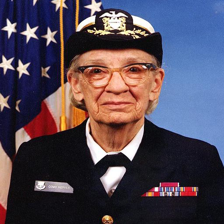

In [6]:
#Run it on a single image
#download a single image to try the model on

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper


In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
#Add batch dimension(with np.newaxis) and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

In [13]:
#result is a 1001-element vector of logits, rating the probability of each class for the image
#top class ID ican be found with tf.math.argmax

predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [14]:
#Decode the predictions
#take the predicted_class ID(like 653) and fetch the ImageNet dataset labels to decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

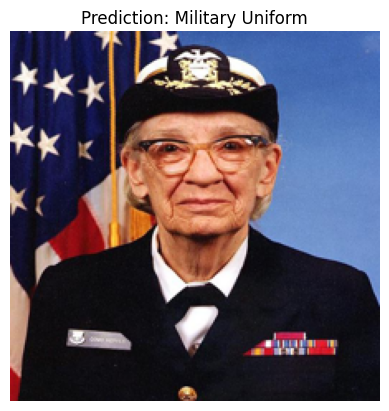

In [15]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
#Simple transfer learning
#if you want to create a custom classifier using your own dataset with classes not included in the original ImageNet?
#select a pre-trained model from Tensorflow Hub
#Retrain the top(last) layer to recognize the classes from your custome dataset

In [16]:
#Dataset
#using tensorflow flowers dataset
data_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228813984/228813984 [==============================] - 2s 0us/step


In [17]:
#First load this data into the model using image data off disk with tf.keras.utils.image_dataset_from_directory
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
#Second, since tfhub's convention is for images models to expect floats between [0, 1], use Rescaling preprocessing layer

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #Where x-images, y-labels
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# Third finish input pipeline by using buffered prefetching(Dataset.prefetch, so you can yield data from disk without I/O blocking issues)


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [21]:
#Run classifier on a batch of images
#run on an image batch
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 124s 1s/step


In [22]:
predicted_class_name = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_name

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

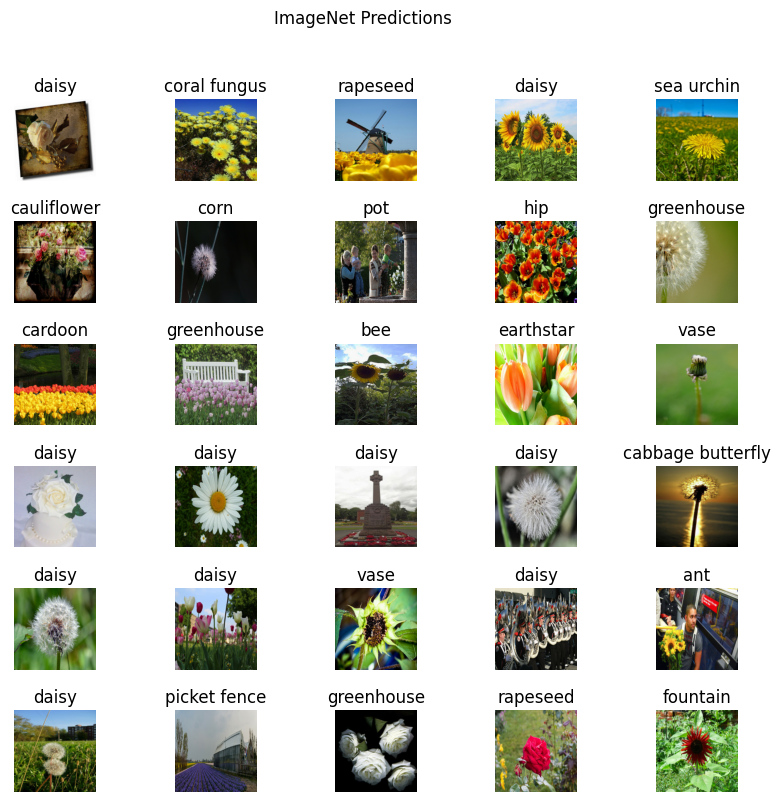

In [23]:
#Now check how these predictions line up with the images
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet Predictions")


In [24]:
#Download the headless model
#select a MobileNetv2 pre-trained model
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [ ]:
#create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer
#use trainable=false to freeze the variable.

In [25]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable = False
)

In [27]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
#Attach a classification head
#to complete the model, wrap the feature extract ;ayer in a tf.kera,Sequential model and add a fully-connected layer for classification

In [31]:
num_classes = len(class_names) #return number of items

model_classes = tf.keras.Sequential([ #groups layers into a model
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)
])

model_classes.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [32]:
predictions = model_classes(image_batch)
predictions.shape

TensorShape([32, 5])

In [ ]:
#Train the model
#use model.compile to configure the training process and add a tf.keras.callback.TensorBoard to create store logs

In [34]:
model_classes.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1  #enables histogram computation for every epochs
)

In [36]:
#Now model.fit will train the model
NUM_EPOCHS = 10

history = model_classes.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
92/92 [==============================] - 144s 2s/step - loss: 0.7671 - acc: 0.7163 - val_loss: 0.4503 - val_acc: 0.8515
Epoch 2/10
92/92 [==============================] - 152s 2s/step - loss: 0.3802 - acc: 0.8675 - val_loss: 0.3604 - val_acc: 0.8856
Epoch 3/10
92/92 [==============================] - 153s 2s/step - loss: 0.2969 - acc: 0.9060 - val_loss: 0.3265 - val_acc: 0.8910
Epoch 4/10
92/92 [==============================] - 163s 2s/step - loss: 0.2470 - acc: 0.9237 - val_loss: 0.3101 - val_acc: 0.8965
Epoch 5/10
92/92 [==============================] - 162s 2s/step - loss: 0.2117 - acc: 0.9404 - val_loss: 0.3010 - val_acc: 0.8951
Epoch 6/10
92/92 [==============================] - 163s 2s/step - loss: 0.1847 - acc: 0.9513 - val_loss: 0.2953 - val_acc: 0.9005
Epoch 7/10
92/92 [==============================] - 161s 2s/step - loss: 0.1633 - acc: 0.9578 - val_loss: 0.2914 - val_acc: 0.9019
Epoch 8/10
92/92 [==============================] - 152s 2s/step - loss: 0.1456 - a

In [ ]:
#start Tensorboard to view how the metrics change with each epoch and to track other scalar values

In [37]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
#Check the predictions
#obtain ordered list of class names from the model predictions

In [39]:
predicted_batch = model_classes.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 3s 3s/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


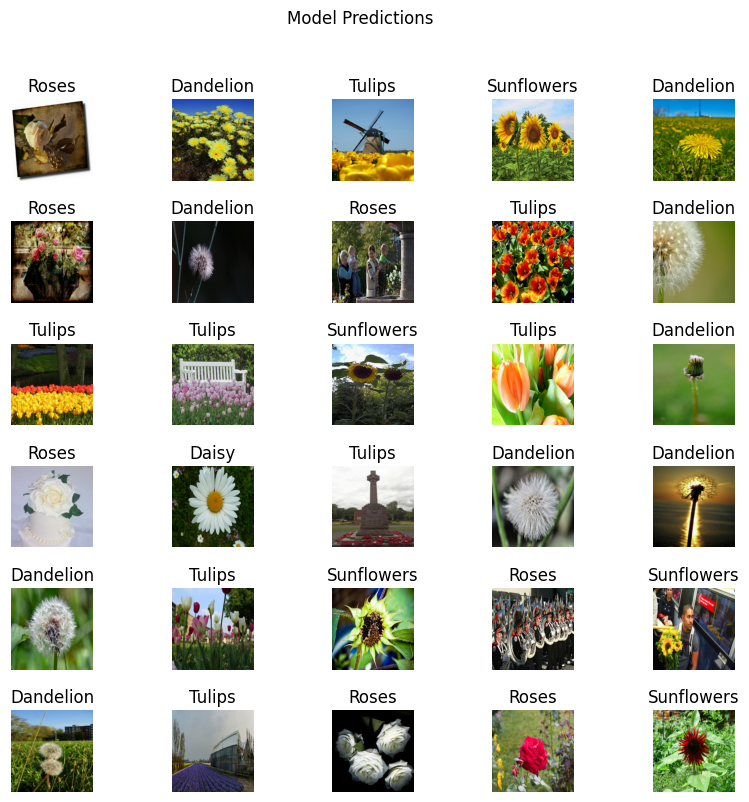

In [43]:
#plot the model predictions
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model Predictions")

In [44]:
#Export and reload the model
#export trained model as a savedmodel to reuse later

t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model_classes.save(export_path)

export_path

'/tmp/saved_models/1687267901'

In [45]:
reloaded = tf.keras.models.load_model(export_path)

In [46]:
result_batch = model_classes.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [47]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [2]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

NameError: ignored

NameError: ignored

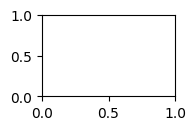

In [4]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")